# **버퍼 캐시**

Buffer Cache는 SGA(공유메모리영역)의 한 부분으로 Storage I/O Access를 최소화 하고 특히 Random I/O 성능 영향을 최소화 하는 중요한 역할을 한다.

- 우리가 한번 사용한 디스크의 Data Block을 Buffer Cache에 올려놓고 같은 Block이 필요한 경우 디스크에 갈 필요없이 메모리에서 데이터를 바로 사용할 수 있다. ( SQL수행 속도에 가장큰 영향을 미치는 부분이 디스크 I/O 이기 때문에 이부분을 최소화 하는게 성능향상에 도움이 된다. )

- 사용자가 입력한 데이터를 데이터 파일에 저장한 뒤 다시 읽는 과정에서 거쳐가는 캐시영역.
- 최근에 사용한 블록에 대한 정보를 저장하는 메모리의 일정 영역으로 물리적인 I/O를 최소화.


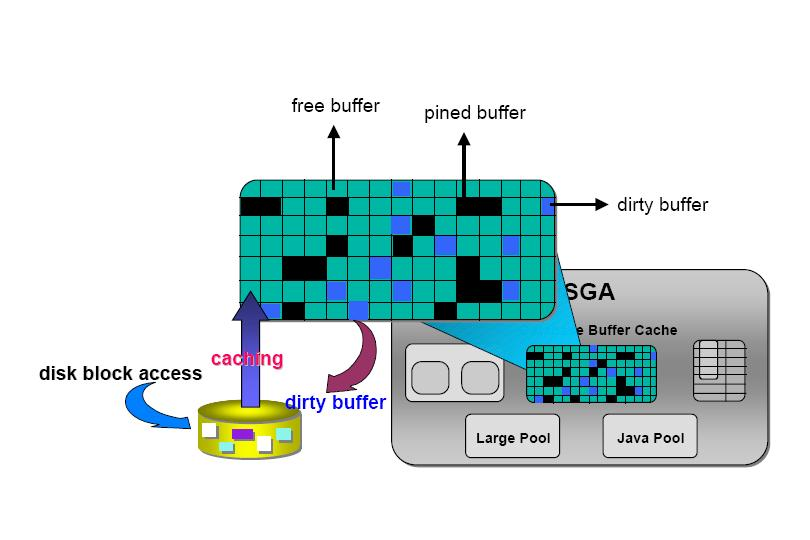

# **블록단위 I/O**


- 메모리 버퍼 캐시에서 버퍼 블록을 액세스 할때
- 데이터파일에 저장된 데이터 블록을 DB 버퍼 캐시로 적재할때
- 캐시에서 변경된 블록을 다시 데이터파일에 저장할 때
- 옵티마이져가 인덱스를 이용해 테이블을 액세스할 지 Full Table Scan을 할 지 결정하는 판단 기준으로 블록 갯수를 사용한다. (중요한 점: 레코드 수가 아님)


**single block I/O**

- 한번의 I/O Call에 하나의 데이터 블록만 읽어 메모리에 적재하는 방법.
- 인덱스를 경유해 테이블 액세스시 사용하는 액세스 방법.

**multi block I/O**

- Call이 필요한 시점에 인접한 블록들을 같이 읽어 메모리에 적재하는 방법이다.
- Extent 범위 단위에서 읽는다.
  - 하나의 Extent 범위를 넘어가면 후에 다시 CALL을 해서 읽는다.
  - 즉, Extent의 범위를 작게 설정하면 그만큼 DB CALL 횟수도 늘어난다.
- Full Table Scan시 사용하는 액세스 방법이다.


# **버퍼 캐시 구조**


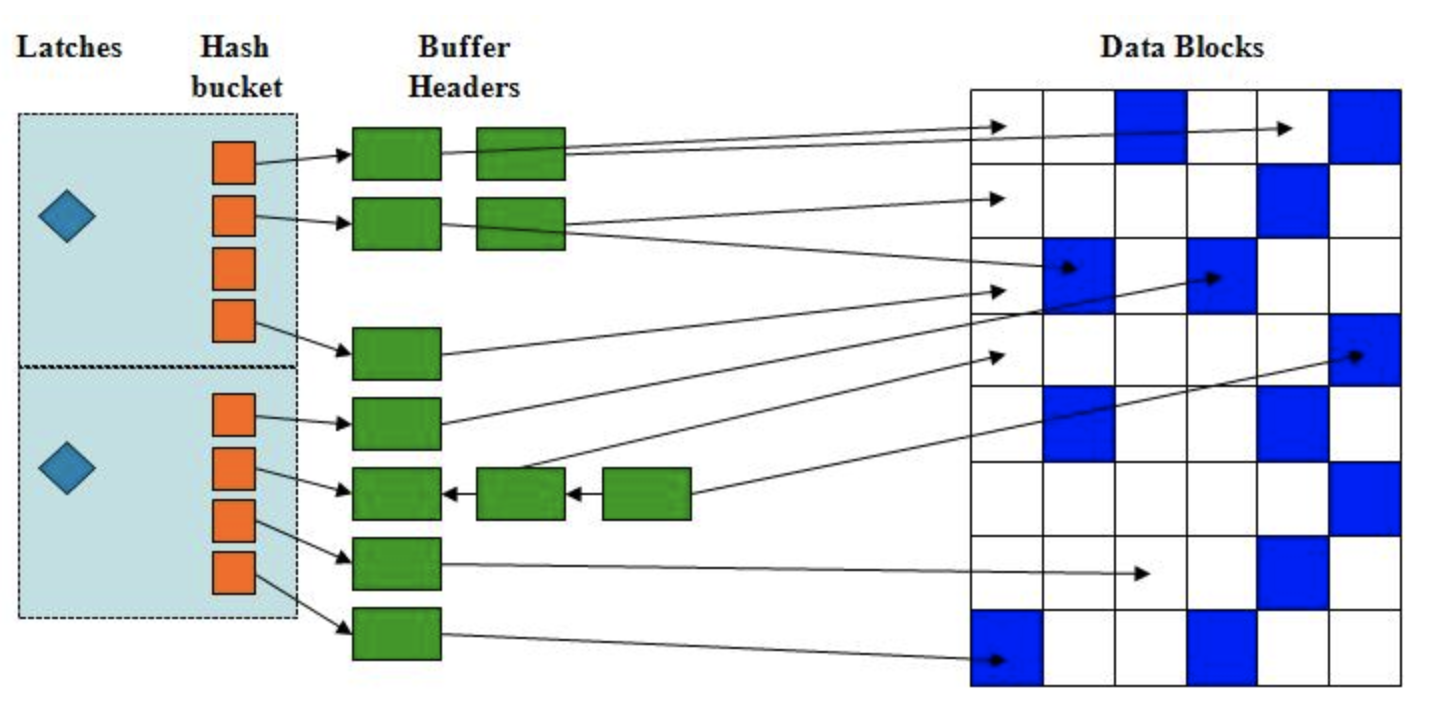

**해시테이블 구조로 관리**

- DBA (Data Block Address ): 실제 Storage 에 물리적인 주소를 이야기하고 해당 주고는 File# + Block# 로 이루어져 있다.

- 찾고자 하는 데이터블록 주소인 DBA(Data Block Address))를 해시값으로 변환하여 해시 해시 키 값으로 사용.
- 해당 해시 버킷에서 체인을 따라 스캔하여 있으면 바로 읽고 없으면 디스크에서 가져와 해시 체인에 연결한 후 읽는다.
- SGA 내에서 가장 많이 사용되는 자료구조.
- 버퍼 헤더만 해시 체인에 연결 되고 데이터 값은 포인터를 이용해 버퍼 블록을 찾아 얻는다.
- 여러개의 해시 버킷으로 구성.
- 해시 버킷과 해시 체인은 1:1 관계.
- 성능 고도화 목표 중 하나로 해시 체인 스캔 비용 최소화가 있다.
- 하나의 해시 체인에 하나의 버퍼만 달리는 것을 목표.

**하나의 해시 버킷의 구성**

- 버킷(Bucket) ==> 체인(Chain) ==> 헤더(Header)의 구조로 되어있다.
- 해시 체인은 Shared Pool 내에 존재.
- 해시 체인은 양방향의 링크된 리스트로 되어있다.

**버퍼 헤더**

- 버퍼에 대한 메타 정보.
- 버퍼 메모리 영역의 실제 버퍼에 대한 포인터 값.


**해싱(hasing) 알고리즘을 주소록으로 쉽게 이해하기**


- Hash Bucket : Hash Table로 만들어 놓고 내부의 참조된 영역은 Linked List 된 구조

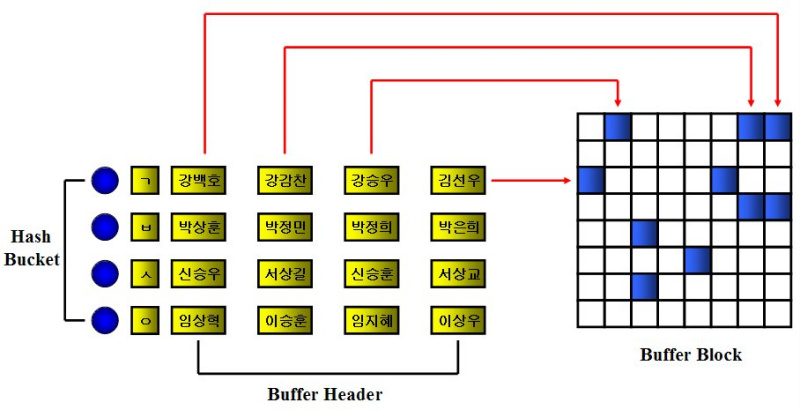

- 성씨가 같은 고객은 같은 페이지(=해시 버킷)내에 있지만 해시 버킷 내에서는 정렬상태를 유지 하지 않아 스캔방식으로 탐색하여 찾아야한다.
- 성능을 위해 각 버킷 내 엔트리 개수 일정 수준 유지가 필요하다.


**버킷 찾아가기**

- 블록의 주소(블록 클래스)를 해시함수에 적용.
- 같은 해시 값을 갖는 버퍼 헤더들이 체인 형태로 있다.
- Latch에 의해 보호되는 자료구조를 이용해 Latch를 획득한 프로세스만 진입을 허용.


**버퍼 캐시 구조를 통한 데이터 액세스의 전체적인 흐름**

1. 해시 테이블 ( Hash table )
2. 해시 버킷 ( Hash bucket )
3. 버퍼 헤더 체인 ( buffer header chain )
4. 버퍼 헤더 ( buffer header )
5. 버퍼 캐시 블록 ( buffer body )
6. 테이블 블록 헤더 ( block header )
7. 테이블 블록 ( block body )

**캐시 버퍼 체인**

- 각 해시 체인은 Latch에 의해 보호.

**래치 (Latch)**

- 같은 리소스에 대한 액세스를 직렬화 하여 리소스를 보호하기 위해 구현된 일종의 Lock 메커니즘.
- 하나의 Latch 가 여러 해시 체인을 동시 보호.
- 버퍼 헤더에 Pin 설정 시 cache buffers chains Latch를 사용.
- Oracle 9i 부터 읽기전용일 경우 cache buffers chains 래치를 Share모드로 획득이 가능.
- 체인 구조 변경 혹은 버퍼 헤더에 Pin 설정 시 Exclusive 모드로 변경.


**캐시 버퍼 체인 래치의 대기 이벤트**


- 버퍼 캐시를 사용하기 위해 해시 체인을 탐색하거나 변경하려는 프로세스들이 래치를 획득하는 과정에서 경합이 발생.
- 캐시 버퍼 체인 래치 경합이 발생하는 대표적인 경우
  - 비효율적인 SQL문장 사용 : 동시에 여러 프로세스가 넓은 범위의 인덱스나 넓은 범위의 테이블에 대해 스캔을 수행하는 경우에 발생.
  - 핫블록(Hot Block) 현상 : SQL 문의 작동방식이 소수의 특정 블록을 계속해서 스캔하는 형태로 작성되었다면, 여러 세션이 동시에 이 SQL 문을 수행 할 때 경합이 발생.


**캐시 버퍼 LRU 체인**

- LRU (Least Recently Used) : 가장 오랫동안 참조되지 않은 페이지를 교체하는 기법

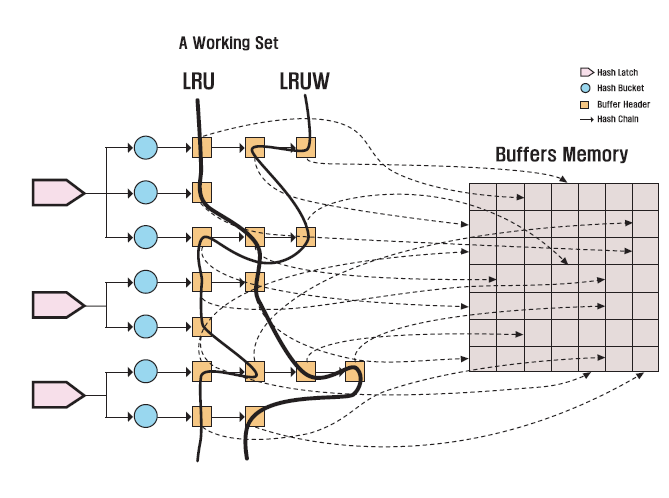

- 두 종류의 LRU(Least Recently Used) 리스트를 사용.
- 모든 버퍼 블록 헤더를 LRU 체인에 연결하는데 이 때 둘 중 하나의 LRU 리스트에 속한다.


**LRUW(LRU Write) List (= Dirty 리스트 )**

- 캐시 내에서 변경됐지만, 아직 디스크에 기록되지 않은 Dirty버퍼 블록들을 관리.
- 변경 시 리스트에서 잠시 나온다.
- LRUW(LRU Write)리스트 라고도 한다.

**LRU List**


- 아직 Dirty 리스트로 옮겨지지 않은 나머지 버퍼블록들을 관리.
- 변경 시 Dirty 리스트(LRUW 리스트)로 이동.

**모든 버퍼 블록은 셋중 하나의 상태이다.**

- Free 버퍼 (Free Buffer)
  - 빈 상태 혹은 데이터 파일과 동기화 된 상태.
  - 언제든 덮어 쓸 수 있으며 변경 시 Dirty 버퍼가 된다.
- Dirty 버퍼 (Dirty Buffer)
  - 변경 되어 데이터 파일과 동기화가 필요한 상태.
  - 동기화 되면 Free 버퍼가 된다.
- Pinned 버퍼
  - 읽기/쓰기 작업 중인 버퍼 블록을 의미.

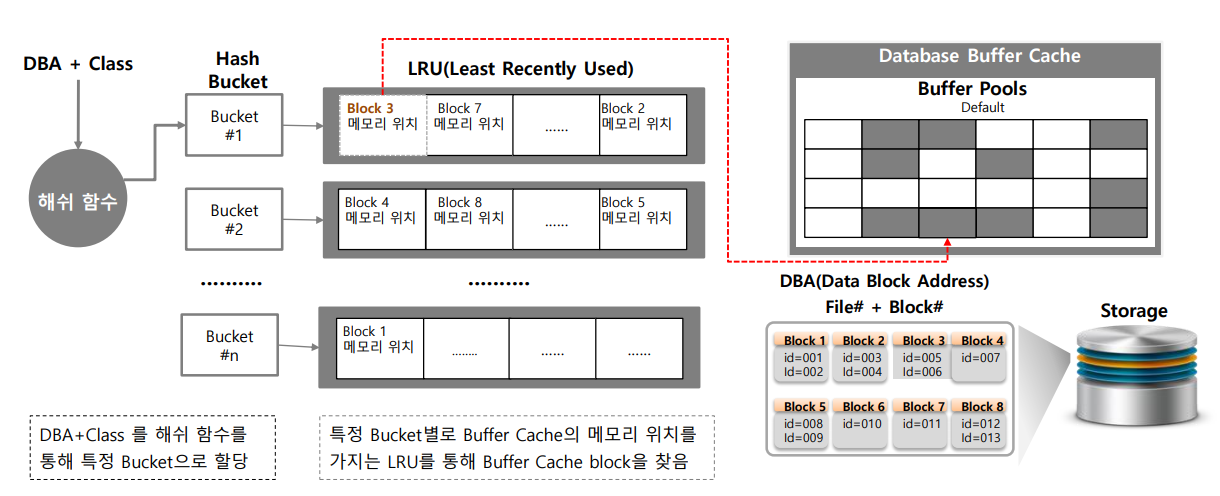

**Buffer Cache Access 메커니즘**

- SELECT * FROM CUSTOMER WHERE ID='005'로 조회.
- 데이터 딕셔너리 에서 DBA(Data Block Address) 정보를 찾는다.
- DBA + Class 로 해쉬함수에 전달하면 Hash Bucket의 위치를 알려준다.
- Hash Bucket의 특정 위치에 해당하는 Linked List 를 순차검색.



**순차 검색에서 원하는 DBA정보가 없다면 ?**

- Storage 에 접근해서 (I/O발생 성능에 좋지안음) DBA에 맞는 Block을 가져온다.
- 가져온 Block을 Buffer Cache에 올려둔다.
- Buffer Cache에 올려둔 위치를 알 수 있도록 Hash Bucket에 Buffer Cache위치를 저장해놓는다.


**순차 검색에서 원하는 DBA정보가 있다면 ?**

- Buffer Cache의 위치에 찾아가서 Block정보를 가지고 요청된 SQL에 응답한다.

**정리**

- 간단히 말해서 Buffer Cache는 성능에 매우 취약한 I/O Access를 피하도록 하는 방법.
- 이 전략이 가능한 이유는 서버 프로세스들이 서로 공유를 하기 때문에 더욱 효과적.
- Buffer Cache는 SGA(공유메모리 영역) 안에 들어있는 컴포넌트 이기 때문에 모두 공유하고 있다.
- 따라서 다른 프로세스가 올려놓은 Block를 내가 사용할 수도 있는 것.
